In [2]:
"""
    (Successful) Attempt for the controlled version:
"""
import numpy as np
import qiskit
from qiskit.quantum_info import state_fidelity
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py

import sys
sys.path.append("../../src/brickwall_sparse")
from utils_sparse import construct_ising_local_term, reduce_list, X, I2, get_perms
from ansatz_sparse import ansatz_sparse
import rqcopt as oc
from scipy.sparse.linalg import expm_multiply
from qiskit.quantum_info import random_statevector

Lx, Ly = (4, 4)
L = Lx*Ly
t = .25
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 3)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0, -1j], [1j, 0]])
I2 = np.array([[1, 0], [0, 1]])

hloc1 = construct_ising_local_term(J, 0, 0, ndim=2)
hloc2 = g*(np.kron(X, I2)+np.kron(I2, X))/4

V1 = scipy.linalg.expm(-1j*t*hloc1/4)
V2 = scipy.linalg.expm(-1j*t*hloc2/2)
V3 = scipy.linalg.expm(-1j*t*hloc1/2)
V4 = scipy.linalg.expm(-1j*t*hloc2)
YZ = np.kron(Y, Z)

perms_v, perms_h = get_perms(Lx, Ly)
"""perms_v, perms_h = ([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 0, 1, 2, 3, 4, 5]],
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [1, 2, 3, 4, 5, 0, 7, 8, 9, 10, 11, 6, 13, 14, 15, 16, 17, 12, 19, 20, 21, 22, 23, 18, 25, 26, 27, 28, 29, 24, 31, 32, 33, 34, 35, 30]])
"""

Vlist_start = [YZ, V1, V2, V1, YZ, YZ, V3, V4, V3, YZ, YZ, V1, V2, V1, YZ]
Vlist_reduced = [V1, V2, V1, V3, V4, V3, V1, V2, V1]
perms_extended = [[perms_v[0]]] + [perms_v]*3 + [[perms_v[0]], [perms_h[0]]] +\
                    [perms_h]*3 + [[perms_h[0]], [perms_v[0]]] + [perms_v]*3 + [[perms_v[0]]]
perms_ext_reduced = [perms_v]*3  + [perms_h]*3 + [perms_v]*3
control_layers = [0, 4, 5, 9, 10, 14] # 6 control layers

# 12 layers with 6 being controlled, 9 parameters in total.
state = random_statevector(2**L).data
print("Trotter error of the starting point: ", (np.linalg.norm(ansatz_sparse(Vlist_start, L, perms_extended, state) - expm_multiply(
    1j * t * hamil, state), ord=2) + np.linalg.norm(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state) - expm_multiply(
    -1j * t * hamil, state), ord=2))/2)

print('fidelity: ', (state_fidelity(ansatz_sparse(Vlist_start, L, perms_extended, state), expm_multiply(
    1j * t * hamil, state)) + state_fidelity(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state), expm_multiply(
    -1j * t * hamil, state)))/2)


Trotter error of the starting point:  0.18700074386467264
fidelity:  0.9653365026382926


Current error:  0.08563168820711778
Current error:  0.03574975871314787
Current error:  0.026875050711299205
Current error:  0.02070715421878684
Current error:  0.019093986067406164
Current error:  0.019093986067406164
0.019093986067406164


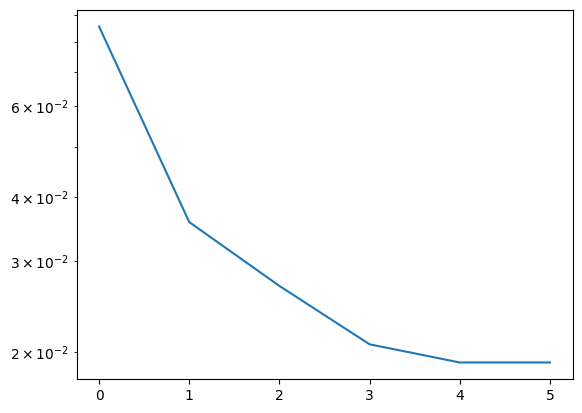

In [9]:
from optimize_sparse import optimize, err

Vlist, f_iter, err_iter = optimize(L, hamil, t, Vlist, perms_extended, perms_reduced=perms_ext_reduced, 
                                   control_layers=control_layers, rS=1, niter=5)
plt.plot(err_iter)
plt.yscale('log')
print(err_iter[-1])

In [15]:
with h5py.File(f"./tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist_start)}_niter7_rS1_2hloc.hdf5", "w") as f:
    f.create_dataset("Vlist", data=Vlist)
    f.create_dataset("f_iter", data=f_iter)
    f.create_dataset("err_iter", data=err_iter)
    f.attrs["L"] = L
    f.attrs["t"] = float(t)

In [3]:
#with h5py.File(f"./tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist_start)}_niter7_rS1_2hloc.hdf5", "r") as f:
#    Vlist =  f["Vlist"][:]

with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx4Ly4_t{t}_layers15_rS1_niter15_3hloc.hdf5", "r") as f:
    Vlist =  f["Vlist"][:]

#with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx4Ly4_t0.5_layers15_rS1_niter30_3hloc.hdf5", "r") as f:
#    Vlist =  f["Vlist"][:]

#with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx4Ly4_t0.25_layers15_rS5_niter20_3hloc.hdf5", "r") as f:
#    Vlist =  f["Vlist"][:]

#with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx4Ly4_t1_layers15_rS1_niter25_3hloc.hdf5", "r") as f:
#    Vlist =  f["Vlist"][:]

In [34]:
"""
    Test operations.
"""

Vlist_reduced = []
for i, V in enumerate(Vlist):
    if i not in control_layers:
        Vlist_reduced.append(V)

state = random_statevector(2**L).data
print("Trotter error of the optimized point: ", (np.linalg.norm(ansatz_sparse(Vlist, L, perms_extended, state) - expm_multiply(
    1j * t * hamil, state), ord=2) + np.linalg.norm(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state) - expm_multiply(
    -1j * t * hamil, state), ord=2))/2)

print('infidelity: ', 1-(state_fidelity(ansatz_sparse(Vlist, L, perms_extended, state), expm_multiply(
    1j * t * hamil, state)) + state_fidelity(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state), expm_multiply(
    -1j * t * hamil, state)))/2)

Trotter error of the optimized point:  0.018472589850104207
infidelity:  0.00034120755032063244


In [ ]:
sys.path.append("../../src/controlled_unitary_optimizer")
sys.path.append("../../src/brickwall_ansatz")
from optimize_3q import optimize_3q 
from utils_3q import make_controlled, random_unitary

Xlists_opt = {}
perms_qc = [[0, 1], [0, 2], [1, 2], [0, 2], [0, 1], [1, 2], [0, 2], [0, 1], [1, 2]]

for i in control_layers:
    cU = make_controlled(Vlist[i])
    f_best, err_best, Glist_best = (0, 2, None)
    for _ in range(10):
        Xlist_start = [random_unitary(4) for i in range(len(perms_qc))]
        Xlist, f_iter, err_iter = optimize_3q(L, cU, Xlist_start, perms_qc, niter=1000)
        if err_iter[-1] < err_best:
            f_best, err_best, Xlist_best = (f_iter[-1], err_iter[-1], Xlist)
    print("Best f: ", f_best)
    print("Best err: ", err_best)
    Xlists_opt[i] = Xlist_best

In [410]:
# Save the optimal gates.

for i in control_layers:
    with h5py.File(f"./results/tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist)}_niter15_rS1_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "w") as file:
        file.create_dataset(f"Xlist_{i}", data=Xlists_opt[i])

In [4]:
#Xlists_opt = {}
#for i in control_layers:
#    with h5py.File(f"./results/tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist)}_niter30_rS1_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "r") as file:
#        Xlists_opt[i] = file[f"Xlist_{i}"][:]

perms_qc = [[0, 1], [0, 2], [1, 2], [0, 2], [0, 1], [1, 2], [0, 2], [0, 1], [1, 2]]
Xlists_opt = {}
for i in control_layers:
    with h5py.File(f"./results/tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist)}_niter20_rS5_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "r") as file:
        Xlists_opt[i] = file[f"Xlist_{i}"][:]


In [23]:
from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit import Aer, execute, transpile
from scipy import sparse as sp


qc = qiskit.QuantumCircuit(L+1)
qc.x(L)
for i, V in enumerate(Vlist):
    layer = i
    if i in control_layers:
        Glist = Xlists_opt[i]
        qc_3 = qiskit.QuantumCircuit(3)
        for j, G in enumerate(Glist):
            qc_3.unitary( G, (3-1-perms_qc[j][1], 3-1-perms_qc[j][0]))

        for perm in perms_extended[layer]:
            for j in range(L//2):
                qc.append(qc_3.to_gate(), [L-perm[2*j]-1, L-perm[2*j+1]-1, L])
        
    else:
        for perm in perms_extended[layer]:
            for j in range(L//2):
                qc.unitary(V, [L-perm[2*j]-1, L-perm[2*j+1]-1])
qc.x(L)


ccU_cxs_05= []
ccU_errs_05 = []
for t in [.25]:
    #state = random_statevector(2**L).data
    qc_ext1 = qiskit.QuantumCircuit(L+1)
    qc_ext1.initialize(state, [i for i in range(L)])
    for i in range(int(t/.25)):
        qc_ext1.append(qc.to_gate(), [i for i in range(L+1)])

    backend = Aer.get_backend("statevector_simulator")
    sv1 = execute(transpile(qc_ext1), backend).result().get_statevector().data

    qc_ext2 = qiskit.QuantumCircuit(L+1)
    qc_ext2.initialize(state, [i for i in range(L)])
    qc_ext2.x(L)
    for i in range(int(t/.25)):
        qc_ext2.append(qc.to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv2 = execute(transpile(qc_ext2), backend).result().get_statevector().data

    ket_0 = np.array([1, 0])
    ket_1 = np.array([0, 1])
    exact_v1 = np.kron(ket_0, expm_multiply(1j * t * hamil, state))
    exact_v2 = np.kron(ket_1, expm_multiply(-1j * t * hamil, state))
    #err = (np.linalg.norm(sv1-exact_v1, ord=2) + np.linalg.norm(sv2-exact_v2, ord=2))/2
    err = (1-state_fidelity(sv1, sv1_T) + 1-state_fidelity(sv2, sv2_T))/2
    
    noise_model = NoiseModel()
    dag = circuit_to_dag(transpile(qc_ext1, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
    count_ops = dag.count_ops()
    
    #ccU_errs_05.append(err)
    #ccU_cxs_05.append(count_ops['unitary'])
    print(f"t={t}, Gate Count: ", count_ops['unitary'], " State infidelity: ", err)
    print("Fidelity: ", 1-err)

t=0.25, Gate Count:  576  State infidelity:  0.0003231784383869729
Fidelity:  0.999676821561613


In [22]:
"""
    Now here is to compare the performance of the ccU circuit
    with the 1st and 2nd order Trotter circuits, in terms of 
    gate count vs Trotter error. I demonstrate it on L=10 system.
"""


def controlled_trotter(c1, L, Lx, Ly, J, g, dag=False, nsteps=1):
    if c1/(2*nsteps) > .25/8:
        nsteps = int(np.ceil(c1/(2 * .25/8)))
        #print("nsteps set to: ", nsteps)
        #print("dt set to: ",  c1/(2*nsteps))
    t = c1/(2*nsteps)

    perms_v, perms_h = get_perms(Lx, Ly)
    indices = oc.SplittingMethod.suzuki(2, 1).indices
    coeffs = oc.SplittingMethod.suzuki(2, 1).coeffs
    perms_ext = ([perms_v, perms_h])*len(indices)
    
    hloc1 = g*(np.kron(X, I2)+np.kron(I2, X))/4
    hloc2 = construct_ising_local_term(J, 0, 0, ndim=2)
    hlocs = (hloc1, hloc2)

    K = []
    for i, perms in enumerate(perms_ext):
        perm = perms[0]
        K_layer = [None for _ in range(L)]
        for j in range(len(perm)//2):
            K_layer[perm[2*j]] = CYGate
            K_layer[perm[2*j+1]] = CZGate
        K.append(K_layer)

    Vlist_start = []
    for i, c in zip(indices, coeffs):
        Vlist_start.append(scipy.linalg.expm(-1j*c*t*hlocs[i]))
    Vlist_gates = []
    for V in Vlist_start:
        qc2 = qiskit.QuantumCircuit(2)
        qc2.unitary(V, [0, 1], label='str')
        Vlist_gates.append(qc2)


    qc = qiskit.QuantumCircuit(L+1)
    for n in range(nsteps):
        for layer, qc_gate in enumerate(Vlist_gates):

            perms = perms_v
            qc.x(L)
            for j in range(L):
                if K[2*layer][j]:
                    qc.append(K[2*layer][j](), [L, L-1-j])
            qc.x(L)

            for perm in perms:
                for j in range(len(perm)//2):
                    qc.append(qc_gate.to_gate(), [L-(perm[2*j]+1), L-(perm[2*j+1]+1)])
            qc.x(L)
            for j in range(L):
                if K[2*layer][j]:
                    qc.append(K[2*layer][j](), [L, L-1-j])
            qc.x(L)

            perms = perms_h
            qc.x(L)
            for j in range(L):
                if K[2*layer+1][j]:
                    qc.append(K[2*layer+1][j](), [L, L-1-j])
            qc.x(L)
            
            for perm in perms:
                for j in range(len(perm)//2):
                    qc.append(qc_gate.to_gate(), [L-(perm[2*j]+1), L-(perm[2*j+1]+1)])

            qc.x(L)
            for j in range(L):
                if K[2*layer+1][j]:
                    qc.append(K[2*layer+1][j](), [L, L-1-j])
            qc.x(L)
    return qc

    
trotter2_cxs_01= []
trotter2_errs_01 = []
for t in [.25]:
    state = random_statevector(2**L).data
    qc_ext1 = qiskit.QuantumCircuit(L+1)
    qc_ext1.initialize(state, [i for i in range(L)])
    qc_ext1.append(controlled_trotter(2*t, 16, 4, 4, J, g).to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv1_T = execute(transpile(qc_ext1), backend).result().get_statevector().data
    
    qc_ext2 = qiskit.QuantumCircuit(L+1)
    qc_ext2.initialize(state, [i for i in range(L)])
    qc_ext2.x(L)
    qc_ext2.append(controlled_trotter(2*t, 16, 4, 4, J, g).to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv2_T = execute(transpile(qc_ext2), backend).result().get_statevector().data

    ket_0 = np.array([1, 0])
    ket_1 = np.array([0, 1])
    exact_v1 = np.kron(ket_0, expm_multiply(1j * t * hamil, state))
    exact_v2 = np.kron(ket_1, expm_multiply(-1j * t * hamil, state))
    #err = (np.linalg.norm(sv1-exact_v1, ord=2) + np.linalg.norm(sv2-exact_v2, ord=2))/2
    err = 1-(state_fidelity(sv1_T, exact_v1) + state_fidelity(sv2_T, exact_v2))/2
    
    noise_model = NoiseModel()
    dag = circuit_to_dag(transpile(qc_ext1, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
    count_ops = dag.count_ops()

    trotter2_cxs_01.append(count_ops['cx']+count_ops['unitary'])
    trotter2_errs_01.append(err)

    print(f"t={t}, State Infid: ", count_ops['cx']+count_ops['unitary'], " Infidelity error: ", err)
    print("Fidelity: ", 1-err)

t=0.25, State Infid:  2304  Infidelity error:  2.356413147330816e-05
Fidelity:  0.9999764358685267


In [130]:
ccU_cxs_05, ccU_errs_05, ccU_cxs_025, ccU_errs_025

([576, 1152, 2304, 4608, 9216],
 [0.2532232933675261,
  0.39798305127620504,
  0.6090405568942865,
  0.8716493435772545,
  1.1463195810590454],
 [1152, 2304, 4608, 9216, 18432],
 [0.029867591447663863,
  0.048491323358095785,
  0.07496480677266779,
  0.11391560987497312,
  0.17740598121523138])

In [147]:
trotter2_cxs_025, trotter2_errs_025, trotter4_cxs_025, trotter4_errs_025, trotter2_cxs_01, trotter2_errs_01

([576, 1152, 2304, 4608, 9216],
 [0.5306171155906878,
  0.7703229298109936,
  1.1107812412467406,
  1.3757915021912899,
  1.4055907460356083],
 [2112, 4224, 8448, 16896, 33792],
 [0.05219243545044751,
  0.05728821073767086,
  0.07393344336815677,
  0.1032147091032222,
  0.15709416825657802],
 [1440, 2880, 5760, 11520, 23040],
 [0.07178451559318078,
  0.11271658882009589,
  0.19089771666549374,
  0.348165418278789,
  0.6408472559919827])

<Figure size 700x500 with 0 Axes>

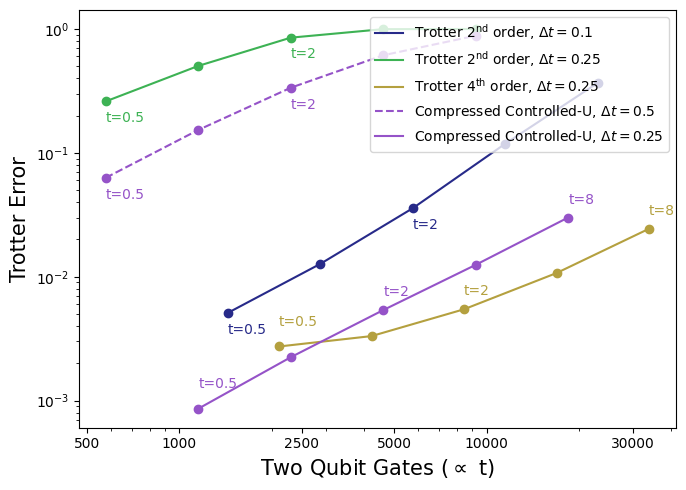

In [251]:
import matplotlib
plt.subplots_adjust(left=0.2, bottom=0.1, right=0.9, top=0.8, wspace=0.1, hspace=0.2)
plt.rcParams["figure.figsize"] = (7, 5)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

fig1, ax1 = plt.subplots()
colors = ((39/256, 42/256  , 138/256), (61/256, 179/256 , 84/256 ), (181/256, 161/256, 63/256 ), 
          (150/256, 83/256, 201/256), (150/256, 83/256, 201/256))
labs = (r'Trotter $2^{\text{nd}}$ order, $\Delta t = 0.1$', r'Trotter $2^{\text{nd}}$ order, $\Delta t = 0.25$', 
        r'Trotter $4^{\text{th}}$ order, $\Delta t = 0.25$', 
        r'Compressed Controlled-U, $\Delta t = 0.5$', r'Compressed Controlled-U, $\Delta t = 0.25$')
ts = [.5, 1, 2, 4, 8]

plt.xlabel(r'Two Qubit Gates ($\propto$ t)', size=15)
plt.ylabel('Trotter Error', size=15)
#plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45])


plots = ((trotter2_cxs_01, trotter2_errs_01), (trotter2_cxs_025, trotter2_errs_025), (trotter4_cxs_025, trotter4_errs_025),
        (ccU_cxs_05, ccU_errs_05), (ccU_cxs_025, ccU_errs_025))

for i, pl in enumerate(plots):
    if i in [3]:
        plt.plot(pl[0], pl[1], label=labs[i], color=colors[i],  ls='--')
    else:
        plt.plot(pl[0], pl[1], label=labs[i], color=colors[i])
    plt.scatter(pl[0], pl[1], color=colors[i])
for i, pl in enumerate(plots):
    if i in [2, 4]:
        annotations = [((f"t={t}" if t in [0.5, 2, 8] else ""), ((0, 15) if t in [0.5] else (0, 10) )) for t in ts]
    else:
        annotations = [((f"t={t}" if t in [0.5, 2] else ""), (0, -15)) for t in ts]
        
    for xi, yi, text in zip(pl[0], pl[1], annotations):
        plt.annotate(text[0], xy=(xi, yi), xycoords='data', size=10, xytext=text[1], textcoords='offset points', color=colors[i])


plt.tight_layout()
plt.legend(loc="upper right", prop={'size': 10})
#plt.title("Controlled-U of anisotropic Heisenberg model for 20 qubits \n", size=15)


ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticks([500, 1000, 2500, 5000, 10000, 30000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.savefig('./figs/tfim_2d_ccU_trotter_and_cxs.pdf', dpi=300, bbox_inches='tight')
plt.savefig('./figs/tfim_2d_ccU_trotter_and_cxs.png', dpi=300, bbox_inches='tight')
plt.show()

In [187]:
heis_trotter2_cxs, heis_trotter2_errs = ([1500, 3000, 4500, 6000], [0.1807771842225962, 0.30265263944132426, 0.38777533456822233, 0.45531193293427574]) 

heis_trotter4_cxs, heis_trotter4_errs = ([2700, 5400, 8100, 10800], [0.09796044777174191, 0.1667859590777272, 0.2146021833049138, 0.2526482471716145]) 

heis_ccU_cxs, heis_ccU_errs = ([640, 1280, 1920, 2560], [0.08059105781840381, 0.12653934797482738, 0.16659943098685642, 0.20574073191569148])

In [283]:
heis_trotter2_cxs, heis_trotter2_errs = ([1500, 3000, 6000, 12000, 24000], [0.03241546030627451, 0.08949535834360933, 0.1967914804052564, 0.38680092213082595, 0.669696443272971]) 

heis_trotter4_cxs, heis_trotter4_errs = ([2700, 5400, 10800, 21600, 43200], [0.00958795546090474, 0.027594282691393968, 0.06259240213165973, 0.13041234071372165, 0.25530834496287635] ) 

heis_ccU_cxs, heis_ccU_errs = ([640, 1280, 2560, 5120, 10240], [0.006538903159281073, 0.016303027068848897, 0.04358304395959711, 0.13252421117720548, 0.3699680431412762])

<Figure size 1400x500 with 0 Axes>

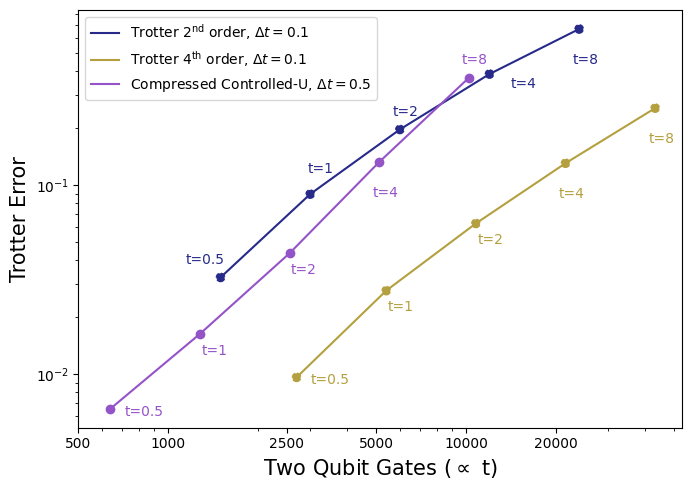

In [284]:
import matplotlib
plt.subplots_adjust(left=0.2, bottom=0.1, right=0.9, top=0.8, wspace=0.1, hspace=0.2)
plt.rcParams["figure.figsize"] = (7, 5)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

fig1, ax1 = plt.subplots()
color1 = (39/256, 42/256  , 138/256)
color2 = (150/256, 83/256, 201/256)
color3 = (181/256, 161/256, 63/256 )
plt.xlabel(r'Two Qubit Gates ($\propto$ t)', size=15)
plt.ylabel('Trotter Error', size=15)
plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45])

heis_colors = ((39/256, 42/256  , 138/256), (181/256, 161/256, 63/256 ), (150/256, 83/256, 201/256))
heis_labs = (r'Trotter $2^{\text{nd}}$ order, $\Delta t = 0.1$', 
             r'Trotter $4^{\text{th}}$ order, $\Delta t = 0.1$', 
             r'Compressed Controlled-U, $\Delta t = 0.5$')

plt.plot(heis_trotter2_cxs, heis_trotter2_errs, label=heis_labs[0], color=heis_colors[0])
plt.scatter(heis_trotter2_cxs, heis_trotter2_errs, ls='--', color=heis_colors[0])

plt.plot(heis_trotter4_cxs, heis_trotter4_errs, label=heis_labs[1], color=heis_colors[1])
plt.scatter(heis_trotter4_cxs, heis_trotter4_errs, ls='--', color=heis_colors[1])

plt.plot(heis_ccU_cxs, heis_ccU_errs, label=heis_labs[2], color=heis_colors[2])
plt.scatter(heis_ccU_cxs, heis_ccU_errs, color=heis_colors[2])

annotations = [("t=0.5", (-25, 10)), ("t=1", (-2, 15)), ("t=2", (-5, 10)), ("t=4", (15, -10)), ("t=8", (-5, -25))]
for xi, yi, text in zip(heis_trotter2_cxs, heis_trotter2_errs, annotations):
    plt.annotate(text[0], xy=(xi, yi), xycoords='data', size=10, xytext=text[1], textcoords='offset points', color=heis_colors[0])

annotations = [("t=0.5", (10, -5)), ("t=1", (1, -15)), ("t=2", (1, -15)), ("t=4", (-5, -25)), ("t=8", (-5, -25))]
for xi, yi, text in zip(heis_trotter4_cxs, heis_trotter4_errs, annotations):
    plt.annotate(text[0], xy=(xi, yi), xycoords='data', size=10, xytext=text[1], textcoords='offset points', color=heis_colors[1])

annotations = [("t=0.5", (10, -5)), ("t=1", (1, -15)), ("t=2", (1, -15)), ("t=4", (-5, -25)), ("t=8", (-5, 10))]
for xi, yi, text in zip(heis_ccU_cxs, heis_ccU_errs, annotations):
    plt.annotate(text[0], xy=(xi, yi), xycoords='data', size=10, xytext=text[1], textcoords='offset points', color=heis_colors[2])


plt.tight_layout()
plt.legend(loc="upper left", prop={'size': 10})
#plt.title("Controlled-U of anisotropic Heisenberg model for 20 qubits \n", size=15)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticks([500, 1000, 2500, 5000, 10000, 20000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.show()

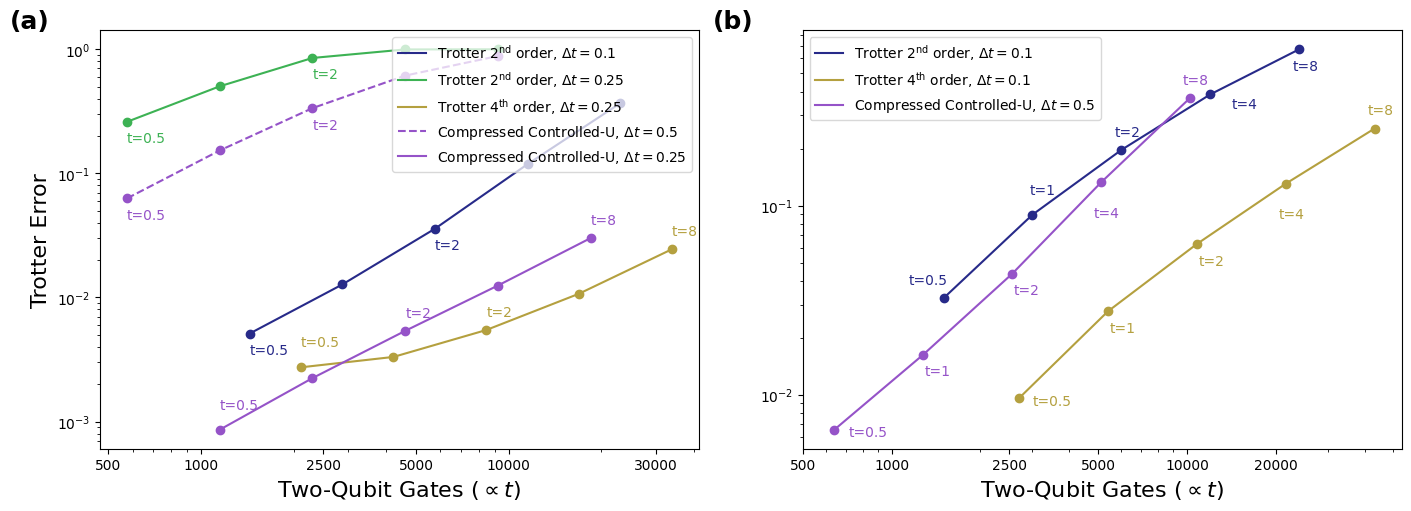

In [288]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["figure.figsize"] = (14, 5)      # twice as wide

# ---------- make one figure with two side‑by‑side axes ----------
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)  # or use wspace with fig.subplots_adjust

# ----------------------------------------------------------------
# 1) LEFT‑HAND PLOT  –– your TFIM data
# ----------------------------------------------------------------
for i, (xs, ys) in enumerate(plots):
    ls = '--' if i == 3 else '-'
    ax1.plot(xs, ys, ls=ls, color=colors[i], label=labs[i])
    ax1.scatter(xs, ys, color=colors[i])

    # prepare the same annotation lists you already built
    if i in (2, 4):
        ann = [((f"t={t}" if t in (0.5, 2, 8) else ""), ((0, 15) if t == 0.5 else (0, 10)))
               for t in ts]
    else:
        ann = [((f"t={t}" if t in (0.5, 2) else ""), (0, -15)) for t in ts]

    for (x, y), (text, offset) in zip(zip(xs, ys), ann):
        if text:
            ax1.annotate(text, (x, y), xytext=offset,
                         textcoords='offset points', color=colors[i], fontsize=10)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticks([500, 1000, 2500, 5000, 10000, 30000])
ax1.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax1.set_xlabel(r'Two‑Qubit Gates ($\propto t$)', fontsize=16)
ax1.set_ylabel('Trotter Error', fontsize=16)
ax1.legend(loc='upper right', fontsize=9, frameon=False)

# ----------------------------------------------------------------
# 2) RIGHT‑HAND PLOT –– your Heisenberg data
# ----------------------------------------------------------------
heis_colors = ((39/256, 42/256, 138/256),
               (181/256, 161/256, 63/256),
               (150/256, 83/256, 201/256))
heis_labs = (r'Trotter $2^{\text{nd}}$ order, $\Delta t = 0.1$',
             r'Trotter $4^{\text{th}}$ order, $\Delta t = 0.1$',
             r'Compressed Controlled‑U, $\Delta t = 0.5$')

series = [
    (heis_trotter2_cxs, heis_trotter2_errs, heis_colors[0]),
    (heis_trotter4_cxs, heis_trotter4_errs, heis_colors[1]),
    (heis_ccU_cxs,      heis_ccU_errs,      heis_colors[2]),
]
for (xs, ys, c), lab in zip(series, heis_labs):
    ax2.plot(xs, ys, color=c, label=lab)
    ax2.scatter(xs, ys, color=c)

# the three annotation blocks you already have
ann_t2  = [("t=0.5", (-25, 10)), ("t=1", (-2, 15)),
           ("t=2", (-5, 10)), ("t=4", (15, -10)), ("t=8", (-5, -15))]
ann_t4  = [("t=0.5", (10, -5)),  ("t=1", (1, -15)),
           ("t=2", (1, -15)),  ("t=4", (-5, -25)), ("t=8", (-5, 10))]
ann_ccU = ann_t4

for (xs, ys, c), ann in zip(series, (ann_t2, ann_t4, ann_ccU)):
    for (x, y), (text, offset) in zip(zip(xs, ys), ann):
        ax2.annotate(text, (x, y), xytext=offset, textcoords='offset points', color=c, fontsize=10)
        

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xticks([500, 1000, 2500, 5000, 10000, 20000])
ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax2.set_xlabel(r'Two‑Qubit Gates ($\propto t$)', fontsize=16)

leg1 = ax1.legend(loc='upper right', fontsize=10, frameon=True)
leg1.get_frame().set_facecolor('white')
leg1.get_frame().set_alpha(0.75)

leg2 = ax2.legend(loc='upper left', fontsize=10, frameon=True)
leg2.get_frame().set_facecolor('white')
leg2.get_frame().set_alpha(0.75)

ax1.text(-0.15, 1.05, "(a)", transform=ax1.transAxes,
         fontsize=18, fontweight='bold', va='top', ha='left')

ax2.text(-0.15, 1.05, "(b)", transform=ax2.transAxes,
         fontsize=18, fontweight='bold', va='top', ha='left')


# ----------------------------------------------------------------
# global tweaks (optional)
# ----------------------------------------------------------------
fig.align_ylabels()              # nice vertical alignment of y‑labels
fig.savefig('./figs/trotter_vs_ccu_side_by_side_v2.pdf', dpi=300, bbox_inches='tight')
plt.show()
